In [83]:
from IPython.display import clear_output

from datetime import datetime as dt
import numpy as np
from datetime import timedelta
import pandas as pd
import pickle

import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [84]:
# importing original dataframes
transactions = pd.read_csv('transactions.csv')
accounts = pd.read_csv('accounts.csv')

In [85]:
transactions.head()

,account_id,date,amount
0,0,2020-10-16,200.0
1,0,2020-10-16,-192.0
2,0,2020-10-16,200.0
3,0,2020-10-16,-24.0
4,0,2020-10-16,-50.0


In [86]:
accounts.head()

,id,balance,update_date
0,0,13.63,2021-07-02
1,1,12.91,2021-07-02
2,2,19.84,2021-07-02
3,3,130.00,2021-07-02
4,4,2806.75,2021-07-02


In [87]:
# making dates datetime objects for easier manipulation
transactions['date'] = transactions['date'].apply(lambda x: dt.strptime(x, '%Y-%m-%d'))
accounts['update_date'] = accounts['update_date'].apply(lambda x: dt.strptime(x, '%Y-%m-%d'))

# merge the two dataframes
data = pd.merge(transactions, accounts, how='inner', left_on='account_id', right_on='id')
data['time_delta'] = data[['date', 'update_date']].apply(lambda x: (x[1] - x[0]).days, axis=1)

In [88]:
# 
def get_ids_enough_history(data, threshold=180):
    """
    A utility function that checks if an account has more than 180 days
    IN : data (dataframe)
    OUT : valid_ids (list)
    """
    seniority = dict(data.groupby('account_id').agg({'time_delta': 'max'}).to_records())
    valid_ids = [key for key in seniority.keys() if seniority[key] >= threshold]
    return valid_ids

valid_ids = get_ids_enough_history(data)
print(valid_ids[:5])

[0, 1, 4, 7, 8]


In [91]:
print('valid ids : ', round(100*(len(valid_ids)/len(data.account_id.unique())), 2), '%')

valid ids :  68.58 %


In [92]:
# Duplicate rows will be removed (same transaction at the same day with th same amount must be an error)
df = data.drop_duplicates()

In [57]:
def correctDateRecord(record, start_date, end_date):
    """
    A utility function that transforms a list of the form {"date1": value, "date2": value....} by imputing
    missing dates with a value of 0. Missing dates are all of those from start_date to end_date that are not 
    in record.keys()
    
    IN : record (dict), start_date (datetime), end_date (datetime)
    OUT : record (dict)
    """
    stringKeys = {str(key).split('T')[0]: value for key, value in record.items()}
    list_dates = [str(start_date + timedelta(days=x)).split(' ')[0] \
                  for x in range((end_date-start_date).days)]
    corrected_record = [[day, stringKeys[day]] if day in list(stringKeys.keys()) else [day, 0] for day in list_dates]
    return dict(corrected_record)

def getBalances(last_balance, outGoings, inGoings):
    """
    A utility function that calculates balance per day 
    
    IN : last_balance (float), outGoings (dict), inGoings (dict)
    OUT : record (dict)
    """
    balance = {}
    current_balance = last_balance
    # reverse engineering balance
    for (date, ingoing), (_, outgoing) in zip(inGoings.items(), outGoings.items()):
        current_balance = current_balance - abs(ingoing) + abs(outgoing)
        balance[date] = current_balance
    return balance

def calculateLastAmounts(self, records, n_months=5, is_balance=False):
    """
    A utility function that calculates values per month for the last n_months of the record 
    
    IN : records (dict)
    OUT : values (list of n_months element)
    """
    v = list(records.values())
    n = len(v)
    # hypothesis : 1 month == 30 days
    if is_balance:
        retVal = [v[n-i*30-1] for i in range(n_months)]
    else:
        retVal = [sum(v[n-i*30: n-(i-1)*30]) for i in range(1, n_months+1)]
    return retVal

# Hypothesis 
- A month is a 30 day period
- No trasactions are made between the last recorded transaction and the update date
- The input features will be calculated on a 5 months period, the 6th months will be used for testing

# Generating training data

* After aggregating data per account Id, we will get a timeseries of transactions + the balance and update date. 
* Since we only need 6 months of history (5 for training + 1 for test), we can create a back rolling window of 6 months in order to generate more data points for our model to learn from  

In [105]:
# generating records per account_id

LOOK_BACK_WINDOW = 5 # months
data = []

for account_id, group in df[df.account_id.isin(valid_ids)].groupby('account_id'):
    clear_output()
    print('Treating id : ', account_id)
    
    # aggregatin/calculating outgoings/ingoings
    outGoings = dict(group[group.amount < 0].groupby('date', sort=True)\
                                         .agg({'amount': 'sum'}).to_records())
    inGoings = dict(group[group.amount > 0].groupby('date', sort=True)\
                                         .agg({'amount': 'sum'}).to_records())
    
    # calculating max/min dates
    if len(inGoings)==0:
        min_date = list(outGoings.keys())[0]
        max_date = list(outGoings.keys())[-1]
    elif len(outGoings)==0:
        min_date = list(inGoings.keys())[0]
        max_date = list(inGoings.keys())[-1]
    else:
        min_date = min(list(outGoings.keys())[0],
                       list(inGoings.keys())[0])
        max_date = min(list(outGoings.keys())[-1],
                       list(inGoings.keys())[-1])
    min_date = dt.strptime(str(min_date).split('T')[0], '%Y-%m-%d')
    max_date = dt.strptime(str(max_date).split('T')[0], '%Y-%m-%d')
    max_date = max(max_date, dt.strptime(str(group['update_date'].values[0]).split('T')[0], '%Y-%m-%d'))
    
    # making the three records of the same length (min_date -> max_date)
    outGoings = correctDateRecord(outGoings, min_date, max_date)
    inGoings = correctDateRecord(inGoings, min_date, max_date)
    balances = getBalances(group['balance'].values[0], outGoings, inGoings)
    assert len(outGoings) == len(inGoings) == len(balances)
    
    # For each account_id, make all 180 days possible shifts 
    number_of_possible_shifts = int(len(outGoings)/30) - 6
    outgoings = list(outGoings.values())
    ingoings = list(inGoings.values())
    balances = list(balances.values())
    n = len(outgoings)
    for shift in range(number_of_possible_shifts + 1):
        # calculating last n amounts for outgoings, ingoings and balances
        x_outgoing, x_ingoings, x_balances = [], [], []
        for i in range(1, LOOK_BACK_WINDOW+2):
            start_index = (n-shift) - i*30
            end_index = (n-shift) - (i-1)*30
            if i == 1: # last month
                y_outgoing = sum(outgoings[start_index: end_index])
                y_ingoing = sum(ingoings[start_index: end_index])
                y_balance = sum(balances[start_index: end_index])
            else:
                x_outgoing.append(sum(outgoings[start_index: end_index]))
                x_ingoings.append(sum(ingoings[start_index: end_index]))
                x_balances.append(sum(balances[start_index: end_index]))
        data.append(x_outgoing+x_ingoings+x_balances+[y_outgoing, y_ingoing, y_balance, account_id])

data_training = pd.DataFrame(data, columns = ['outgoing_'+str(i) for i in range(len(x_outgoing))]+\
                                            ['ingoing_'+str(i) for i in range(len(x_ingoings))]+\
                                            ['balance_'+str(i) for i in range(len(x_balances))]+\
                                            ['y_outgoing', 'y_ingoing', 'y_balance', 'account_id'])
data_training.head()

Treating id :  1253


,outgoing_0,outgoing_1,outgoing_2,outgoing_3,outgoing_4,ingoing_0,ingoing_1,ingoing_2,ingoing_3,ingoing_4,balance_0,balance_1,balance_2,balance_3,balance_4,y_outgoing,y_ingoing,y_balance,account_id
0,-3927.52,-1704.70,-491.20,-484.00,-1474.29,4892.8,2610.5,485.0,1050.00,2229.0,-75414.08,-51901.90,-34025.40,-15573.70,-8676.60,-4293.89,5150.0,-109637.19,0
1,-3322.02,-2148.70,-431.20,-100.00,-1474.29,4892.8,2610.5,1485.0,100.00,2179.0,-74448.80,-50996.10,-34031.60,-15007.70,-7921.89,-4899.39,5150.0,-108781.08,0
2,-3322.02,-2183.20,-396.70,-100.00,-1482.46,4301.8,2610.5,1485.0,100.00,2179.0,-72878.02,-50534.30,-32977.80,-15007.70,-7217.18,-4527.49,5361.0,-108530.47,0
3,-6000.00,-2165.81,-2116.34,-6403.24,-4808.05,5976.0,2165.0,3900.0,6392.33,4820.4,-53019.44,-53165.97,-48863.02,31.13,24.14,-1644.50,1657.0,-52854.50,1
4,-5835.00,-2165.81,-2116.34,-7944.03,-3267.26,5811.0,2165.0,3900.0,7892.33,3320.4,-53043.44,-53166.78,-47079.36,20.22,36.49,-1809.50,1822.0,-52842.00,1


In [93]:
len(data_training)

8751

In [107]:
# how many training data points per account id ?
data_training.groupby('account_id').agg({'account_id': 'count'})

,account_id
account_id,
0,3
1,2
4,4
7,11
8,18
...,...
1249,31
1250,8
1251,9


In [75]:
# saving training data
data_training.to_csv('training_data.csv')

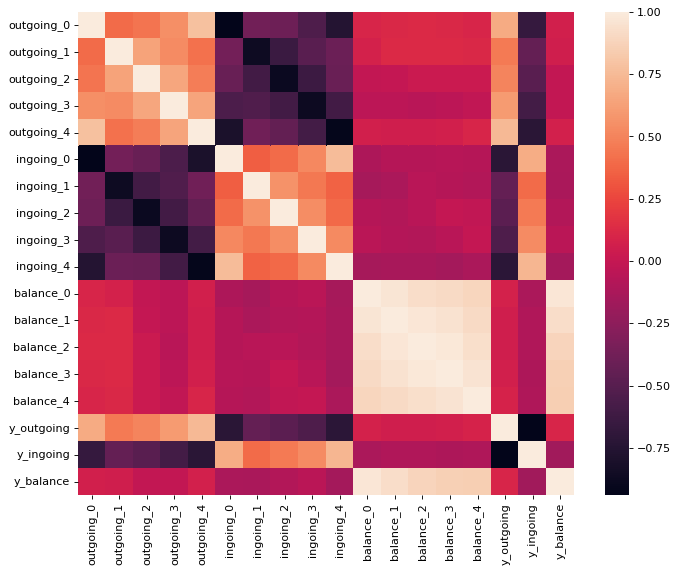

In [76]:
# Correlations between features

figure(figsize=(10, 8), dpi=80)

corr = data_training.corr()
sns.heatmap(corr, xticklabels = data_training.columns, yticklabels=data_training.columns)
plt.show()

For the target variable (y_outgoing), we have:
* slightly positive correlation with previous-balance features
* a quite negative correlation with previous-ingoing features
* a highly positive correlation with previous-outgoing features, especially the one representing the last month (outgoing_4)

# Model training and hyper parameter tuning

In [78]:
X = data_training.drop(['y_outgoing', 'y_ingoing', 'y_balance', 'account_id'], axis=1)
y = data_training['y_outgoing']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=369) # Tesla's lucky number :)

In [111]:
def xgbc_cv(max_depth, learning_rate, n_estimators, reg_alpha, colsample_bytree):
    global X_train, X_test, y_train, y_test
    
    params = {'objective': 'reg:squarederror',
              'max_depth': int(max_depth),
              'reg_alpha': reg_alpha,
              'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'rmse'}

    dtrain = xgb.DMatrix(X_train, label=y_train)
    """
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = colsample_bytree, 
                              learning_rate = learning_rate, max_depth = int(max_depth), 
                              alpha = reg_alpha, n_estimators = int(n_estimators))
    xg_reg.fit(X_train, y_train)
    
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    
    preds = xg_reg.predict(X_test)
    #mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    """
    warnings.simplefilter("ignore")
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]
    return r2


hyperparameter_space = {
    'max_depth': (5, 20),
    'colsample_bytree' : (0.1, 0.5),
    'learning_rate': (0.01, 0.3),
    'n_estimators' : (50, 500),
    'reg_alpha': (0, 1)
}

xgbcBO = BayesianOptimization(f = xgbc_cv, 
                             pbounds =  hyperparameter_space,
                             random_state = 369,
                             verbose = -1)

gp_params = {"alpha": 1e-10}


import warnings


xgbcBO.maximize(init_points=10 ,n_iter=30, acq='ucb', kappa= 3, **gp_params)
print(xgbcBO.max)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | reg_alpha |
-------------------------------------------------------------------------------------
[19:17:25] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:17:25] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:17:25] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This 

|  5        | -2.742e+0 |  0.4788   |  0.183    |  12.59    |  170.6    |  0.9245   |
[19:18:05] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:18:05] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:18:05] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  t

|  10       | -2.79e+03 |  0.2821   |  0.1258   |  13.84    |  81.43    |  0.07473  |
[19:18:49] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:18:49] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:18:49] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  t

|  15       | -2.736e+0 |  0.1079   |  0.1877   |  12.36    |  98.25    |  0.49     |
[19:19:36] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:19:36] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:19:36] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  t

|  20       | -6.695e+0 |  0.1      |  0.01     |  19.8     |  110.1    |  0.0      |
[19:20:21] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:20:21] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:20:21] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  t

|  25       | -2.868e+0 |  0.1      |  0.3      |  12.94    |  397.0    |  1.0      |
[19:21:13] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:21:13] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:21:13] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  t

|  30       | -3.795e+0 |  0.4331   |  0.06101  |  6.804    |  82.79    |  0.1281   |
[19:21:52] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:21:52] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:21:52] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  t

|  35       | -2.738e+0 |  0.2873   |  0.0962   |  19.32    |  438.2    |  0.813    |
[19:22:39] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:22:39] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:22:39] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  t

|  40       | -3.038e+0 |  0.188    |  0.2657   |  16.03    |  237.3    |  0.8052   |
{'target': -2729.0624266, 'params': {'colsample_bytree': 0.38055484372539505, 'learning_rate': 0.18046217876259396, 'max_depth': 13.79819433767964, 'n_estimators': 87.01196390251367, 'reg_alpha': 0.7819165064740075}}


In [80]:
params = xgbcBO.max['params']
params['n_estimators'] = int(params['n_estimators'])
params['max_depth'] = int(params['max_depth'])

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', **params)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)


print('explained_variance_score', explained_variance_score(y_test, preds))
print('mean_absolute_error', mean_absolute_error(y_test, preds))
print('squared_mean_squared_error', np.sqrt(mean_squared_error(y_test, preds)))
print('r2_score', r2_score(y_test, preds))

explained_variance_score 0.9195925081580313
mean_absolute_error 665.5007066271706
squared_mean_squared_error 2618.0542739373495
r2_score 0.9195831637739805


In [81]:
pickle.dump(xg_reg, open('model_reg.pkl', 'wb'))

An R2 score of 92% is quite good. Here are some approach improvement ideas:

- Adding time related features (for example the update_date) in order to tell the model in which period of the year will the prediction be.
- Use ensembling methods with different forecastingmodels, one for ingoing, one for balance and a third for outgoing.
- Adding features that calculate metrics for the entire transaction history and not only last 5 months. This way we can take advantage of the available data for users who have bigger transaction histories.